In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import string
import pickle
import emoji
import scipy.stats as ss
import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import nltk
nltk.download('omw-1.4')
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.utils import to_categorical, pad_sequences
from textblob import TextBlob
import langid
from langdetect import detect

%matplotlib inline

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kamen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Convert emojis to words 
with open('Emoji_Dict.p', 'rb') as fp:
        Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(mess):
    for emot in Emoji_Dict:
        mess = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), mess)
    return mess

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = convert_emojis_to_word(text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text 
    
#def text_process(mess):
    
#    #Convert emojis to words
#    mess = convert_emojis_to_word(mess)
#    mess = mess.lower() # lowercase text
#    mess = REPLACE_BY_SPACE_RE.sub('', mess) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#    mess = BAD_SYMBOLS_RE.sub('', mess)

    # Check characters to see if they are in punctuation
#    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
#    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
#    stop = ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

#    return stop

In [3]:
clean('Hello, my name is Kamen. I hope you have a good day.')

'hello my name is kamen i hope you have a good day'

In [4]:
#A NEW DAY, NEW OPPORTUNITY
df_tr = pd.read_csv('train.txt',sep=';')
df_tr.rename({'i didnt feel humiliated':'text','sadness':'label'}, axis = 1, inplace=True)
df_v = pd.read_csv('val.txt', sep=';')
df_v.rename({'im feeling quite sad and sorry for myself but ill snap out of it soon':'text','sadness':'label'}, axis = 1, inplace=True)
df_te = pd.read_csv('test.csv', sep=';')
df_te.rename({'im feeling rather rotten so im not very ambitious right now':'text','sadness':'label'}, axis = 1, inplace=True)

In [5]:
df_te

,text,label
0,im updating my blog because i feel shitty,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i was feeling a little vain when i did this one,sadness
4,i cant walk into a shop anywhere where i do no...,fear
...,...,...
1994,i just keep feeling like someone is being unki...,anger
1995,im feeling a little cranky negative after this...,anger
1996,i feel that i am useful to my people and that ...,joy
1997,im feeling more comfortable with derby i feel ...,joy


In [6]:
print('Training data length: ', len(df_tr))
print('Validation data length: ', len(df_v))
print('Testing data length: ', len(df_te))

Training data length:  15999
Validation data length:  1999
Testing data length:  1999


In [3]:
#LSTM
from keras.utils.data_utils import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional

In [8]:
dfs = [df_tr, df_v, df_te]
for df in dfs:
    print('Processing text data')
    df['to_check'] = df['text'].apply(clean)
    print('Encoding y values')
    df['label']=df['label'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
    print('\n')

Processing text data
Encoding y values


Processing text data
Encoding y values


Processing text data
Encoding y values




In [9]:
df_te.head()

,text,label,to_check
0,im updating my blog because i feel shitty,3,im updating my blog because i feel shitty
1,i never make her separate from me because i do...,3,i never make her separate from me because i do...
2,i left with my bouquet of red and yellow tulip...,0,i left with my bouquet of red and yellow tulip...
3,i was feeling a little vain when i did this one,3,i was feeling a little vain when i did this one
4,i cant walk into a shop anywhere where i do no...,4,i cant walk into a shop anywhere where i do no...


In [10]:
X_tr = df_tr['to_check'].values
y_tr = df_tr['label'].values
X_v = df_v['to_check'].values
y_v = df_v['label'].values
X_te = df_te['to_check'].values
y_te = df_te['label'].values
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)
print('Training data shape: ',X_tr.shape,y_tr.shape)
print('Validation data shape: ',X_v.shape,y_v.shape)
print('test data shape: ',X_te.shape,y_te.shape)

Training data shape:  (15999,) (15999,)
Validation data shape:  (1999,) (1999,)
test data shape:  (1999,) (1999,)


In [11]:
#Prepare parameters
n_words = 20000 # cut texts after this 
maxlen = 80
batch_size = 128 

In [12]:
tokenizer = Tokenizer(num_words=n_words, lower=True)
tokenizer.fit_on_texts(X_tr)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15212 unique tokens.


In [13]:
X_tr = tokenizer.texts_to_sequences(X_tr)
X_tr = pad_sequences(X_tr, maxlen=maxlen)
print('Shape of data tensor:', X_tr.shape)

Shape of data tensor: (15999, 80)


In [14]:
#One Hot Encoding Training data
y_tr=to_categorical(y_tr)
y_tr

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [15]:
#X_test
X_v = tokenizer.texts_to_sequences(X_v)
X_v = pad_sequences(X_v, maxlen=maxlen)

In [16]:
#One Hot Encode validation data
y_v = to_categorical(y_v)

In [19]:
#Bidirectional LSTM Model creation
model=Sequential()
model.add(Embedding(15999,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 64)            1023936   
                                                                 
 dropout_1 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 1,529,542
Trainable params: 1,529,542
No

In [20]:
hist=model.fit(X_tr,y_tr,epochs=10,validation_data=(X_v,y_v))

Epoch 1/10
500/500 [==============================] - 681s 1s/step - loss: 1.2609 - accuracy: 0.5130 - val_loss: 0.6959 - val_accuracy: 0.7484
Epoch 2/10
500/500 [==============================] - 618s 1s/step - loss: 0.5438 - accuracy: 0.8074 - val_loss: 0.3256 - val_accuracy: 0.8944
Epoch 3/10
500/500 [==============================] - 616s 1s/step - loss: 0.2889 - accuracy: 0.9016 - val_loss: 0.2525 - val_accuracy: 0.9130
Epoch 4/10
500/500 [==============================] - 629s 1s/step - loss: 0.1957 - accuracy: 0.9314 - val_loss: 0.1916 - val_accuracy: 0.9235
Epoch 5/10
500/500 [==============================] - 627s 1s/step - loss: 0.1546 - accuracy: 0.9451 - val_loss: 0.1861 - val_accuracy: 0.9240
Epoch 6/10
500/500 [==============================] - 646s 1s/step - loss: 0.1280 - accuracy: 0.9519 - val_loss: 0.1836 - val_accuracy: 0.9285
Epoch 7/10
500/500 [==============================] - 620s 1s/step - loss: 0.1164 - accuracy: 0.9559 - val_loss: 0.1734 - val_accuracy: 0.9305

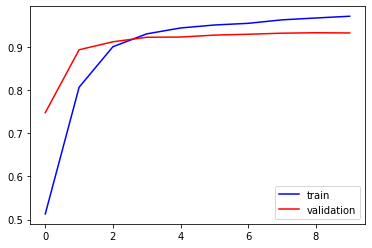

In [21]:
"""
IMPORTANT:
Training data has to come from train.txt
Validation data has to come from val.txt
Test data has to from test.txt
"""
import matplotlib.pyplot as plt 
%matplotlib inline
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

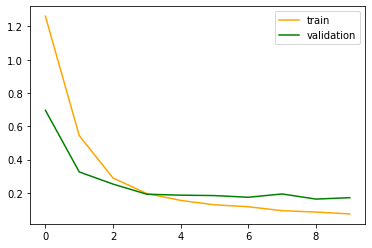

In [22]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

In [23]:
#Let's test the model
X_te = tokenizer.texts_to_sequences(X_te)
X_te = pad_sequences(X_te, maxlen=maxlen)

In [24]:
y_te = to_categorical(y_te)

In [25]:
X_te.shape

(1999, 80)

In [26]:
model.evaluate(X_te,y_te)

63/63 [==============================] - 6s 90ms/step - loss: 0.1756 - accuracy: 0.9300


[0.17562060058116913, 0.9299649596214294]

In [27]:
y_pred=model.predict(X_te)

63/63 [==============================] - 8s 97ms/step


In [28]:
y_pred[1]

array([1.3325469e-05, 1.3220779e-04, 5.6969202e-06, 9.9983454e-01,
       9.4822481e-06, 4.7011895e-06], dtype=float32)

In [29]:
y_test_arg=np.argmax(y_te,axis=1)
Y_pred = np.argmax(model.predict(X_te),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, Y_pred))

63/63 [==============================] - 5s 86ms/step
Confusion Matrix
[[654   3  31   2   0   5]
 [  6 255   0   9   5   0]
 [ 22   0 137   0   0   0]
 [  1   8   0 563   8   0]
 [  0   8   0   5 202   9]
 [  2   1   0   2  13  48]]


In [30]:
#classification report
print(classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       695
           1       0.93      0.93      0.93       275
           2       0.82      0.86      0.84       159
           3       0.97      0.97      0.97       580
           4       0.89      0.90      0.89       224
           5       0.77      0.73      0.75        66

    accuracy                           0.93      1999
   macro avg       0.89      0.89      0.89      1999
weighted avg       0.93      0.93      0.93      1999



In [31]:
model.save('LSTM_mod2.h5')

In [45]:
#Define function for new input
#Add textBlob to have all languages included
#Prepare parameters
n_words = 20000 # cut texts after this 
maxlen = 80
batch_size = 128
tokenizer = Tokenizer(num_words=n_words, lower=True)
def dico(arg): 
    val_dict = {'joy':0,
                'anger':1,
                'love':2,
                'sadness':3,
                'fear':4,
                'surprise':5}
    for key, val in val_dict.items():
        if val == arg: 
            return key

def predict_new_data(text):

    #Handle data that is not english
    text = TextBlob(text).correct()
    text = str(text)
    lang_detect = str(langid.classify(text))[2:4]
    print(lang_detect)
    if lang_detect != "en": 
        text = TextBlob(text).translate(from_lang = lang_detect, to = "en")
        print(text)
        
    text = str(text)
    #Prepare data to feed the model
    text = clean(text)
    sen_list = []
    sen_list.append(text) 
    tokenizer.fit_on_texts(sen_list)
    text_seq = tokenizer.texts_to_sequences(sen_list)
    text_pad = pad_sequences(text_seq, maxlen=maxlen)
    model = load_model('LSTM_mod2.h5')
    return dico(np.argmax(model.predict(text_pad)))

In [47]:
string = "i don't know what to do"
print("What the human said: ", string)
print("Predicted emotion by the AI: ", predict_new_data(string))

What the human said:  i don't know what to do
en
1/1 [==============================] - 2s 2s/step
Predicted emotion by the AI:  surprise
